In [1]:
import os, re, random
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
@dataclass
class CFG:
    ROOT: str = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026/Kaggle_Prepared"  
    TRAIN_DIR: str = "train"
    VAL_DIR: str = "val"

    USE_RGB: bool = True
    USE_MS: bool  = True
    USE_HS: bool  = True

    LOAD_SIZE:int = 64
    IMG_SIZE: int = 64

    BATCH_SIZE: int = 128  
    EPOCHS: int = 100
    LR: float = 2e-4
    WD: float = 0.05

    NUM_WORKERS: int = 4
    SEED: int = 3557

    RGB_BACKBONE: str = "convnext_base"  
    AMP: bool = True

    HS_DROP_FIRST: int = 10
    HS_DROP_LAST: int = 14

    OUT_DIR: str = "/kaggle/working/"
    BEST_CKPT: str = "best.pt"


LABELS = ["Health", "Rust", "Other"]
LBL2ID = {k: i for i, k in enumerate(LABELS)}
ID2LBL = {i: k for k, i in LBL2ID.items()}

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def list_files(folder: str, exts: Tuple[str, ...]) -> List[str]:
    if not os.path.isdir(folder):
        return []
    out = []
    for fn in os.listdir(folder):
        if fn.lower().endswith(exts):
            out.append(os.path.join(folder, fn))
    return sorted(out)

def base_id(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

def parse_label_from_train_name(bid: str) -> Optional[str]:
    m = re.match(r"^(Health|Rust|Other)_", bid)
    return m.group(1) if m else None

def build_index(root: str, split: str) -> Dict[str, Dict[str, str]]:
    split_dir = os.path.join(root, split)
    rgb_dir = os.path.join(split_dir, "RGB")
    ms_dir  = os.path.join(split_dir, "MS")
    hs_dir  = os.path.join(split_dir, "HS")

    rgb_files = list_files(rgb_dir, (".png", ".jpg", ".jpeg"))
    ms_files  = list_files(ms_dir, (".tif", ".tiff"))
    hs_files  = list_files(hs_dir, (".tif", ".tiff"))

    idx: Dict[str, Dict[str, str]] = {}
    for p in rgb_files:
        idx.setdefault(base_id(p), {})["rgb"] = p
    for p in ms_files:
        idx.setdefault(base_id(p), {})["ms"] = p
    for p in hs_files:
        idx.setdefault(base_id(p), {})["hs"] = p
    return idx
    
def center_crop(x: torch.Tensor, size: int) -> torch.Tensor:
    _, h, w = x.shape
    top = (h - size) // 2
    left = (w - size) // 2
    return x[:, top:top+size, left:left+size]

def random_crop(x: torch.Tensor, size: int) -> torch.Tensor:
    _, h, w = x.shape
    if h == size and w == size:
        return x
    top = random.randint(0, h - size)
    left = random.randint(0, w - size)
    return x[:, top:top+size, left:left+size]
    
def make_train_df(train_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in train_idx.items():
        lab = parse_label_from_train_name(bid)
        if lab is None:
            continue
        rows.append({
            "base_id": bid,
            "label": lab,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

def make_val_df(val_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in val_idx.items():
        rows.append({
            "base_id": bid,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

def stratified_holdout(df: pd.DataFrame, frac: float = 0.1, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    parts = []
    for lab, g in df.groupby("label"):
        n = max(1, int(len(g) * frac))
        parts.append(g.iloc[:n])
    df_va = pd.concat(parts).drop_duplicates("base_id")
    df_tr = df[~df["base_id"].isin(df_va["base_id"])].reset_index(drop=True)
    df_va = df_va.reset_index(drop=True)
    return df_tr, df_va

In [4]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def fix_channels(x: torch.Tensor, target_c: int) -> torch.Tensor:
    # x: (C,H,W) -> (target_c,H,W) by crop or zero-pad
    c, h, w = x.shape
    if c == target_c:
        return x
    if c > target_c:
        return x[:target_c]
    pad = torch.zeros((target_c - c, h, w), dtype=x.dtype)
    return torch.cat([x, pad], dim=0)
    
def read_rgb(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = torch.from_numpy(img).permute(2, 0, 1)  # (3,H,W)
    x = (x - IMAGENET_MEAN) / IMAGENET_STD      
    return x

def read_tiff_multiband(path: str) -> np.ndarray:
    arr = tiff.imread(path)  # (H,W,C) or (C,H,W)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D TIFF, got {arr.shape} for {path}")
    if arr.shape[0] < arr.shape[1] and arr.shape[0] < arr.shape[2]:
        arr = np.transpose(arr, (1, 2, 0))  # -> (H,W,C)
    return arr

def normalize_per_band_minmax(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    H, W, C = x.shape
    flat = x.reshape(-1, C)
    mn = flat.min(axis=0)
    mx = flat.max(axis=0)
    denom = (mx - mn)
    denom[denom < eps] = 1.0
    x = (x - mn.reshape(1, 1, C)) / denom.reshape(1, 1, C)
    return np.clip(x, 0.0, 1.0)

def read_ms(path: str) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,5)
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (5,H,W)

def read_hs(path: str, drop_first: int, drop_last: int) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,B)
    B = arr.shape[2]
    if B > (drop_first + drop_last + 1):
        arr = arr[:, :, drop_first:B - drop_last]
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (B',H,W)

def resize_tensor(x: torch.Tensor, size: int) -> torch.Tensor:
    # x: (C,H,W) -> (C,size,size)
    return F.interpolate(x.unsqueeze(0), size=(size, size), mode="bilinear", align_corners=False).squeeze(0)

def apply_joint_aug(x_rgb, x_ms, x_hs):
    k = random.randint(0, 3)
    do_h = random.random() < 0.5
    do_v = random.random() < 0.5

    def _tf(x):
        if x is None:
            return None
        if k:
            x = torch.rot90(x, k, dims=(1, 2))
        if do_h:
            x = torch.flip(x, dims=(2,))
        if do_v:
            x = torch.flip(x, dims=(1,))
        return x

    return _tf(x_rgb), _tf(x_ms), _tf(x_hs)

def infer_hs_in_ch(df_train: pd.DataFrame, df_val: pd.DataFrame, cfg: CFG) -> int:
    for df in (df_train, df_val):
        if "hs" in df.columns:
            for p in df["hs"].dropna().tolist():
                if p and os.path.exists(p):
                    x = read_hs(p, cfg.HS_DROP_FIRST, cfg.HS_DROP_LAST)
                    return int(x.shape[0])
    return 101

In [5]:
class WheatMultiModalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cfg: CFG, hs_in_ch: int, train: bool):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.hs_in_ch = hs_in_ch
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        bid = row["base_id"]

        x_rgb = x_ms = x_hs = None
        m_rgb = m_ms = m_hs = 0.0

        if self.cfg.USE_RGB and row.get("rgb") is not None:
            x_rgb = read_rgb(row["rgb"])
            x_rgb = resize_tensor(x_rgb, self.cfg.LOAD_SIZE)
            x_rgb = random_crop(x_rgb, self.cfg.IMG_SIZE) if self.train else center_crop(x_rgb, self.cfg.IMG_SIZE)
            m_rgb = 1.0

        if self.cfg.USE_MS and row.get("ms") is not None:
            x_ms = read_ms(row["ms"])
            x_ms = resize_tensor(x_ms, self.cfg.LOAD_SIZE)
            x_ms = random_crop(x_ms, self.cfg.IMG_SIZE) if self.train else center_crop(x_ms, self.cfg.IMG_SIZE)
            m_ms = 1.0


        if self.cfg.USE_HS and isinstance(row.get("hs"), str) and row["hs"]:
            x_hs = read_hs(row["hs"], self.cfg.HS_DROP_FIRST, self.cfg.HS_DROP_LAST)
            x_hs = fix_channels(x_hs, self.hs_in_ch) 
            x_hs = resize_tensor(x_hs, self.cfg.LOAD_SIZE)
            x_hs = random_crop(x_hs, self.cfg.IMG_SIZE) if self.train else center_crop(x_hs, self.cfg.IMG_SIZE)
            m_hs = 1.0
    
        if self.train:
            x_rgb, x_ms, x_hs = apply_joint_aug(x_rgb, x_ms, x_hs)

        if self.cfg.USE_RGB and x_rgb is None:
            x_rgb = torch.zeros(3, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if self.cfg.USE_MS and x_ms is None:
            x_ms = torch.zeros(5, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if self.cfg.USE_HS and x_hs is None:
            x_hs = torch.zeros(self.hs_in_ch, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)

        mask = torch.tensor([m_rgb, m_ms, m_hs], dtype=torch.float32)

        if "label" in row:
            y = LBL2ID[row["label"]]
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask, "y": torch.tensor(y, dtype=torch.long)}
        else:
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask}

In [6]:
class EnhancedSpectralEncoder(nn.Module):
    """改进的光谱编码器 - 引入光谱注意力和残差连接"""
    
    def __init__(self, in_ch: int, emb_dim: int = 256, use_spectral_attention=True):
        super().__init__()
        self.use_spectral_attention = use_spectral_attention
        
        # 光谱降维层（特别针对高光谱）
        if in_ch > 32:
            self.spectral_reduce = nn.Sequential(
                nn.Conv2d(in_ch, 64, kernel_size=1),
                nn.BatchNorm2d(64),
                nn.GELU(),
                nn.Conv2d(64, 32, kernel_size=1),
                nn.BatchNorm2d(32),
                nn.GELU()
            )
            in_ch_reduced = 32
        else:
            self.spectral_reduce = nn.Identity()
            in_ch_reduced = in_ch
        
        # 光谱注意力机制
        if use_spectral_attention:
            self.spectral_attention = SpectralAttentionBlock(in_ch_reduced)
        
        # 残差块序列
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(in_ch_reduced, 64, stride=1),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2),
        ])
        
        # 全局上下文模块
        self.global_context = GlobalContextBlock(256)
        
        # 输出层
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
    def forward(self, x):
        # 光谱降维（针对高光谱）
        x = self.spectral_reduce(x)
        
        # 光谱注意力
        if self.use_spectral_attention:
            x = self.spectral_attention(x)
        
        # 残差块
        for block in self.residual_blocks:
            x = block(x)
        
        # 全局上下文
        x = self.global_context(x)
        
        # 输出
        return self.head(x)


class SpectralAttentionBlock(nn.Module):
    """光谱注意力：学习不同波段的重要性"""
    
    def __init__(self, in_channels):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.attention_net = nn.Sequential(
            nn.Linear(in_channels, max(4, in_channels // 8)),
            nn.GELU(),
            nn.Linear(max(4, in_channels // 8), in_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        # 全局平均池化获取每个波段的全局统计
        pooled = self.gap(x).view(B, C)  # [B, C]
        # 计算注意力权重
        weights = self.attention_net(pooled).view(B, C, 1, 1)  # [B, C, 1, 1]
        # 应用注意力
        return x * weights


class ResidualBlock(nn.Module):
    """残差块"""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.activation = nn.GELU()
        
        # 下采样连接
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.activation(out)
        
        return out


class GlobalContextBlock(nn.Module):
    """全局上下文模块"""
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.channels = channels
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        y = self.gap(x).view(B, C)  # [B, C]
        y = self.fc(y).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * y.expand_as(x)


class EnhancedMultiModalNet(nn.Module):
    """改进的多模态网络 - 引入跨模态注意力和渐进式融合"""
    
    def __init__(self, cfg: CFG, hs_in_ch: int, n_classes: int = 3):
        super().__init__()
        self.use_rgb = cfg.USE_RGB
        self.use_ms  = cfg.USE_MS
        self.use_hs  = cfg.USE_HS
        
        # 1. 各模态编码器（增强版）
        if self.use_rgb:
            # 使用更强的骨干网络
            self.rgb_enc = timm.create_model(
                cfg.RGB_BACKBONE, 
                pretrained=True, 
                num_classes=0, 
                global_pool="avg"
            )
            rgb_dim = self.rgb_enc.num_features  # convnext_base: 1024
            
            # RGB特征增强
            self.rgb_enhancer = nn.Sequential(
                nn.Linear(rgb_dim, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(512, 256),
            )
            rgb_out_dim = 256
        else:
            self.rgb_enc = None
        
        if self.use_ms:
            # 多光谱编码器（增强）
            self.ms_enc = EnhancedSpectralEncoder(in_ch=5, emb_dim=256, use_spectral_attention=True)
            ms_out_dim = 256
        else:
            self.ms_enc = None
        
        if self.use_hs:
            # 高光谱编码器（增强）
            self.hs_enc = EnhancedSpectralEncoder(in_ch=hs_in_ch, emb_dim=256, use_spectral_attention=True)
            hs_out_dim = 256
        else:
            self.hs_enc = None
        
        # 2. 跨模态注意力融合模块
        fusion_dims = []
        if self.use_rgb:
            fusion_dims.append(rgb_out_dim)
        if self.use_ms:
            fusion_dims.append(ms_out_dim)
        if self.use_hs:
            fusion_dims.append(hs_out_dim)
        
        total_fusion_dim = sum(fusion_dims)
        
        # 跨模态注意力
        self.cross_modal_attention = CrossModalAttention(
            rgb_dim=256 if self.use_rgb else 0,
            ms_dim=256 if self.use_ms else 0,
            hs_dim=256 if self.use_hs else 0
        )
        
        # 3. 渐进式特征融合
        self.fusion_net = nn.Sequential(
            nn.Linear(total_fusion_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        
        # 4. 分类头（带注意力）
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, n_classes)
        )
        
        # 5. 模态权重学习（自适应权重）
        self.modal_weight_net = nn.Sequential(
            nn.Linear(total_fusion_dim, 64),
            nn.GELU(),
            nn.Linear(64, 3 if self.use_rgb and self.use_ms and self.use_hs else 2),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, rgb, ms, hs, mask):
        features = []
        modal_features = []
        
        # RGB特征提取
        if self.use_rgb:
            rgb_feat = self.rgb_enc(rgb)  # [B, 1024]
            rgb_feat = self.rgb_enhancer(rgb_feat) * mask[:, 0:1]  # [B, 256]
            features.append(rgb_feat)
            modal_features.append(rgb_feat.unsqueeze(1))  # [B, 1, 256]
        
        # 多光谱特征提取
        if self.use_ms:
            ms_feat = self.ms_enc(ms) * mask[:, 1:2]  # [B, 256]
            features.append(ms_feat)
            modal_features.append(ms_feat.unsqueeze(1))  # [B, 1, 256]
        
        # 高光谱特征提取
        if self.use_hs:
            hs_feat = self.hs_enc(hs) * mask[:, 2:3]  # [B, 256]
            features.append(hs_feat)
            modal_features.append(hs_feat.unsqueeze(1))  # [B, 1, 256]
        
        # 早期融合：拼接特征
        early_fused = torch.cat(features, dim=1)  # [B, total_dim]
        
        # 学习模态权重
        modal_weights = self.modal_weight_net(early_fused)  # [B, 3]
        
        # 加权融合
        weighted_features = []
        start_idx = 0
        for i, feat in enumerate(features):
            weight = modal_weights[:, i:i+1]  # [B, 1]
            weighted_features.append(feat * weight)
        
        # 中期融合：跨模态注意力（如果多个模态）
        if len(modal_features) > 1:
            # 拼接模态特征 [B, num_modalities, 256]
            stacked_modal = torch.cat(modal_features, dim=1)
            # 跨模态注意力
            attended = self.cross_modal_attention(stacked_modal)  # [B, 256]
        else:
            attended = features[0]
        
        # 晚期融合：与加权特征结合
        if len(weighted_features) > 0:
            weighted_sum = torch.stack(weighted_features, dim=1).sum(dim=1)
            combined = attended + weighted_sum
        else:
            combined = attended
        
        # 渐进式融合网络
        fused = self.fusion_net(early_fused)
        
        # 最终融合
        final_features = combined + fused
        
        # 分类
        logits = self.classifier(final_features)
        
        return logits


class CrossModalAttention(nn.Module):
    """跨模态注意力模块"""
    
    def __init__(self, rgb_dim=0, ms_dim=0, hs_dim=0):
        super().__init__()
        
        # 确定模态数量和维度
        self.modalities = []
        dims = []
        if rgb_dim > 0:
            self.modalities.append('rgb')
            dims.append(rgb_dim)
        if ms_dim > 0:
            self.modalities.append('ms')
            dims.append(ms_dim)
        if hs_dim > 0:
            self.modalities.append('hs')
            dims.append(hs_dim)
        
        self.num_modalities = len(self.modalities)
        
        if self.num_modalities < 2:
            # 如果少于2个模态，不需要跨模态注意力
            self.attention = None
            return
        
        # 统一的特征维度
        self.unified_dim = 256
        
        # 投影层（将不同模态投影到统一维度）
        self.projection = nn.ModuleDict()
        for modality, dim in zip(self.modalities, dims):
            self.projection[modality] = nn.Linear(dim, self.unified_dim)
        
        # 多头自注意力
        self.attention = nn.MultiheadAttention(
            embed_dim=self.unified_dim,
            num_heads=4,
            batch_first=True,
            dropout=0.1
        )
        
        # 层归一化
        self.norm = nn.LayerNorm(self.unified_dim)
        
        # 前馈网络
        self.ffn = nn.Sequential(
            nn.Linear(self.unified_dim, self.unified_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.unified_dim * 4, self.unified_dim),
            nn.Dropout(0.1)
        )
        
        # 输出投影
        self.output_proj = nn.Linear(self.unified_dim, self.unified_dim)
    
    def forward(self, modal_features):
        """
        输入: [B, num_modalities, feature_dim]
        输出: [B, unified_dim]
        """
        if self.attention is None or self.num_modalities < 2:
            # 如果是单模态，直接返回平均
            return modal_features.mean(dim=1)
        
        B, M, D = modal_features.shape
        
        # 投影到统一维度
        projected = []
        for i in range(M):
            feat = modal_features[:, i, :]
            modality = self.modalities[i]
            proj_feat = self.projection[modality](feat)
            projected.append(proj_feat)
        
        # [B, M, unified_dim]
        projected = torch.stack(projected, dim=1)
        
        # 自注意力
        attended, _ = self.attention(projected, projected, projected)
        
        # 残差连接和层归一化
        x = self.norm(projected + attended)
        
        # 前馈网络（应用于每个模态）
        ffn_out = self.ffn(x)
        x = self.norm(x + ffn_out)
        
        # 跨模态聚合（平均所有模态）
        aggregated = x.mean(dim=1)  # [B, unified_dim]
        
        # 输出投影
        output = self.output_proj(aggregated)
        
        return output

In [7]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    conf = np.zeros((3, 3), dtype=np.int64)

    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)

        logits = model(rgb, ms, hs, mask)
        pred = logits.argmax(dim=1)

        total += y.size(0)
        correct += (pred == y).sum().item()

        yt = y.cpu().numpy()
        yp = pred.cpu().numpy()
        for t, p in zip(yt, yp):
            conf[t, p] += 1

    acc = correct / max(1, total)

    f1s = []
    for c in range(3):
        tp = conf[c, c]
        fp = conf[:, c].sum() - tp
        fn = conf[c, :].sum() - tp
        prec = tp / max(1, (tp + fp))
        rec  = tp / max(1, (tp + fn))
        f1 = 0.0 if (prec + rec) == 0 else (2 * prec * rec / (prec + rec))
        f1s.append(f1)

    return {"acc": float(acc), "macro_f1": float(np.mean(f1s))}

def train_one_epoch_enhanced(model, loader, optimizer, scaler, device, loss_fn=None):
    """改进的训练循环"""
    model.train()
    total_loss, n = 0.0, 0
    
    for batch in loader:
        rgb = batch["rgb"].to(device)
        ms = batch["ms"].to(device)
        hs = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y = batch["y"].to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            # 前向传播
            if hasattr(model, 'return_features') and model.return_features:
                logits, features, aux_output = model(rgb, ms, hs, mask, return_features=True)
                
                # 获取原始高光谱数据用于重建损失
                if aux_output is not None:
                    # 假设hs是原始高光谱数据
                    original_spectra = hs.mean(dim=[2, 3])  # [B, C_hs]
                    
                    # 计算复合损失
                    if loss_fn is not None:
                        loss, _ = loss_fn(logits, y, features, aux_output, original_spectra)
                    else:
                        loss = F.cross_entropy(logits, y)
                else:
                    loss = F.cross_entropy(logits, y)
            else:
                logits = model(rgb, ms, hs, mask)
                loss = F.cross_entropy(logits, y)
        
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        bs = y.size(0)
        total_loss += loss.item() * bs
        n += bs
    
    return total_loss / max(1, n)

@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    preds = []
    ids = []
    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)

        logits = model(rgb, ms, hs, mask)
        p = logits.argmax(dim=1).cpu().numpy().tolist()
        preds.extend([ID2LBL[x] for x in p])
        ids.extend(batch["id"])
    return ids, preds


In [8]:
cfg = CFG()
seed_everything(cfg.SEED)
os.makedirs(cfg.OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Backbone:", cfg.RGB_BACKBONE)

train_idx = build_index(cfg.ROOT, cfg.TRAIN_DIR)
val_idx   = build_index(cfg.ROOT, cfg.VAL_DIR)

train_df = make_train_df(train_idx)
val_df   = make_val_df(val_idx)

print(f"Indexed train IDs: {len(train_idx)} | usable labeled train rows: {len(train_df)}")
print(f"Indexed val IDs:   {len(val_idx)}   | val rows: {len(val_df)}")

if len(train_df) == 0:
    raise RuntimeError("No training samples found. Check ROOT/train and filename label pattern (Health_/Rust_/Other_).")

hs_in_ch = infer_hs_in_ch(train_df, val_df, cfg)
print("Inferred HS channels after trimming:", hs_in_ch)

df_tr, df_va = stratified_holdout(train_df, frac=0.1, seed=cfg.SEED)
print(f"Train split: {len(df_tr)} | Holdout split: {len(df_va)}")

ds_tr = WheatMultiModalDataset(df_tr, cfg, hs_in_ch=hs_in_ch, train=True)
ds_va = WheatMultiModalDataset(df_va, cfg, hs_in_ch=hs_in_ch, train=False)
ds_te = WheatMultiModalDataset(val_df, cfg, hs_in_ch=hs_in_ch, train=False)

dl_tr = DataLoader(ds_tr, batch_size=cfg.BATCH_SIZE, shuffle=True,
                   num_workers=4, pin_memory=True, drop_last=True,
                   persistent_workers=True, prefetch_factor=4)

dl_va = DataLoader(ds_va, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=4, pin_memory=True,
                   persistent_workers=True, prefetch_factor=4)

dl_te = DataLoader(ds_te, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True)

model = EnhancedMultiModalNet(cfg, hs_in_ch=hs_in_ch, n_classes=3).to(device)

backbone, head = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (backbone if n.startswith("rgb_enc") else head).append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone, "lr": cfg.LR * 0.3}, 
        {"params": head,     "lr": cfg.LR},
    ],
    weight_decay=cfg.WD
)

scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))

best_f1 = -1.0
best_path = os.path.join(cfg.OUT_DIR, cfg.BEST_CKPT)

# Tracking metrics for plotting
history = {
    "epoch": [],
    "train_loss": [],
    "val_acc": [],
    "val_f1": [],
    "checkpoint_epochs": [], # Epochs where chpt was saved
    "checkpoint_f1": [],     # F1 scores at chpt epochs
}


for ep in range(1, cfg.EPOCHS + 1):
    tr_loss = train_one_epoch_enhanced(model, dl_tr, optimizer, scaler if scaler.is_enabled() else None, device)
    metrics = evaluate(model, dl_va, device)
    print(f"Epoch {ep:02d} | loss={tr_loss:.4f} | val_acc={metrics['acc']:.4f} | val_macroF1={metrics['macro_f1']:.4f}")

    # Save history
    history["epoch"].append(ep)
    history["train_loss"].append(tr_loss)
    history["val_acc"].append(metrics["acc"])
    history["val_f1"].append(metrics["macro_f1"])
    
    if metrics["macro_f1"] > best_f1:
        best_f1 = metrics["macro_f1"]
        torch.save({"model": model.state_dict(), "hs_in_ch": hs_in_ch, "cfg": cfg.__dict__}, best_path)
        print(f"  -> saved best to {best_path}")
        
        # Mark checkpoint
        history["checkpoint_epochs"].append(ep)
        history["checkpoint_f1"].append(metrics["macro_f1"])

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"], strict=True)

pred_ids, pred_labels = predict(model, dl_te, device)


sub_ids = []
for _, r in val_df.iterrows():
    if isinstance(r.get("hs"), str) and r.get("hs"):
        sub_ids.append(os.path.basename(r["hs"]))
    elif isinstance(r.get("ms"), str) and r.get("ms"):
        sub_ids.append(os.path.basename(r["ms"]))
    else:
        sub_ids.append(os.path.basename(r["rgb"]))

Device: cuda
Backbone: convnext_base
Indexed train IDs: 600 | usable labeled train rows: 600
Indexed val IDs:   300   | val rows: 300
Inferred HS channels after trimming: 101
Train split: 540 | Holdout split: 60


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

/tmp/ipykernel_24/1329787127.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))
/tmp/ipykernel_24/1664904242.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 01 | loss=1.0890 | val_acc=0.3500 | val_macroF1=0.2222
  -> saved best to /kaggle/working/best.pt
Epoch 02 | loss=0.9266 | val_acc=0.5333 | val_macroF1=0.5013
  -> saved best to /kaggle/working/best.pt
Epoch 03 | loss=0.8176 | val_acc=0.4000 | val_macroF1=0.2911
Epoch 04 | loss=0.7593 | val_acc=0.6000 | val_macroF1=0.4875
Epoch 05 | loss=0.6982 | val_acc=0.4500 | val_macroF1=0.3463
Epoch 06 | loss=0.6128 | val_acc=0.5500 | val_macroF1=0.4400
Epoch 07 | loss=0.5403 | val_acc=0.4667 | val_macroF1=0.3658
Epoch 08 | loss=0.4738 | val_acc=0.5000 | val_macroF1=0.3966
Epoch 09 | loss=0.4278 | val_acc=0.5500 | val_macroF1=0.4809
Epoch 10 | loss=0.2975 | val_acc=0.5667 | val_macroF1=0.4795
Epoch 11 | loss=0.2909 | val_acc=0.6500 | val_macroF1=0.6467
  -> saved best to /kaggle/working/best.pt
Epoch 12 | loss=0.2361 | val_acc=0.6000 | val_macroF1=0.5836
Epoch 13 | loss=0.1953 | val_acc=0.6000 | val_macroF1=0.6009
Epoch 14 | loss=0.1534 | val_acc=0.5333 | val_macroF1=0.4911
Epoch 15 | loss=0

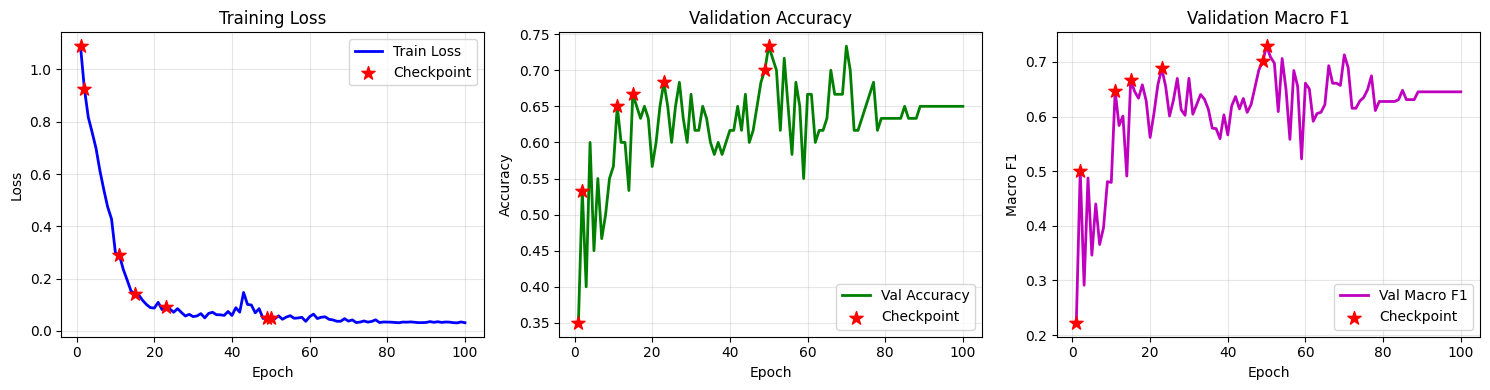


CHECKPOINT SUMMARY
  Checkpoint 1: Epoch 1, Macro F1 = 0.2222
  Checkpoint 2: Epoch 2, Macro F1 = 0.5013
  Checkpoint 3: Epoch 11, Macro F1 = 0.6467
  Checkpoint 4: Epoch 15, Macro F1 = 0.6668
  Checkpoint 5: Epoch 23, Macro F1 = 0.6882
  Checkpoint 6: Epoch 49, Macro F1 = 0.7011
  Checkpoint 7: Epoch 50, Macro F1 = 0.7290

Best checkpoint: Epoch 50, Macro F1 = 0.7290


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Training Loss
axes[0].plot(history["epoch"], history["train_loss"], 'b-', linewidth=2, label='Train Loss')
axes[0].scatter(history["checkpoint_epochs"], 
                [history["train_loss"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[1].plot(history["epoch"], history["val_acc"], 'g-', linewidth=2, label='Val Accuracy')
axes[1].scatter(history["checkpoint_epochs"], 
                [history["val_acc"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Validation Macro F1
axes[2].plot(history["epoch"], history["val_f1"], 'm-', linewidth=2, label='Val Macro F1')
axes[2].scatter(history["checkpoint_epochs"], history["checkpoint_f1"], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Validation Macro F1')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUT_DIR, "training_curves.png"), dpi=150, bbox_inches='tight')
plt.show()

# Print checkpoint summary
print("\n" + "="*50)
print("CHECKPOINT SUMMARY")
print("="*50)
for i, (ep, f1) in enumerate(zip(history["checkpoint_epochs"], history["checkpoint_f1"]), 1):
    print(f"  Checkpoint {i}: Epoch {ep}, Macro F1 = {f1:.4f}")
print(f"\nBest checkpoint: Epoch {history['checkpoint_epochs'][-1]}, Macro F1 = {best_f1:.4f}")
print("="*50)


Generating predictions for confusion matrix...
Confusion matrix saved to: /kaggle/working/confusion_matrix.png


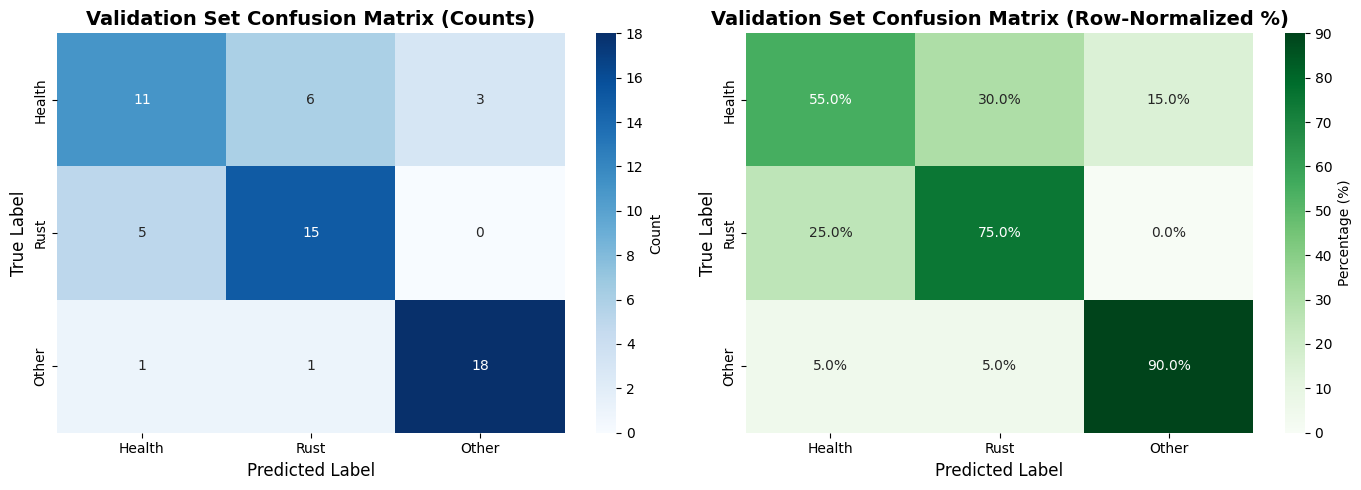


PER-CLASS METRICS
Class              Precision       Recall     F1-Score    Support
------------------------------------------------------------
Health                0.6471       0.5500       0.5946         20
Rust                  0.6818       0.7500       0.7143         20
Other                 0.8571       0.9000       0.8780         20
------------------------------------------------------------
Overall Accuracy: 0.7333 (44/60)


In [10]:
# ============================================================================
# Confusion Matrix Visualization
# ============================================================================
from sklearn.metrics import confusion_matrix as sklearn_cm
import seaborn as sns

@torch.no_grad()
def get_predictions_and_labels(model, loader, device):
    """Get all predictions and true labels from a dataloader"""
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)
        
        logits = model(rgb, ms, hs, mask)
        preds = logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix", save_path=None):
    """
    Plot a beautiful confusion matrix with counts and percentages
    """
    # Compute confusion matrix
    cm = sklearn_cm(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_title(f'{title} (Counts)', fontsize=14, fontweight='bold')
    
    # Plot 2: Percentages
    annot_pct = np.array([[f'{val:.1f}%' for val in row] for row in cm_normalized])
    sns.heatmap(cm_normalized, annot=annot_pct, fmt='', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_title(f'{title} (Row-Normalized %)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print per-class metrics
    print("\n" + "="*60)
    print("PER-CLASS METRICS")
    print("="*60)
    print(f"{'Class':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
    print("-"*60)
    
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        support = cm[i, :].sum()
        
        precision = tp / max(1, tp + fp)
        recall = tp / max(1, tp + fn)
        f1 = 2 * precision * recall / max(1e-8, precision + recall)
        
        print(f"{class_name:<15} {precision:>12.4f} {recall:>12.4f} {f1:>12.4f} {support:>10d}")
    
    # Overall metrics
    total_correct = np.diag(cm).sum()
    total_samples = cm.sum()
    accuracy = total_correct / total_samples
    
    print("-"*60)
    print(f"{'Overall Accuracy:':<15} {accuracy:.4f} ({total_correct}/{total_samples})")
    print("="*60)
    
    return cm

# Get predictions on validation set
print("Generating predictions for confusion matrix...")
y_pred_val, y_true_val = get_predictions_and_labels(model, dl_va, device)

# Plot confusion matrix
cm = plot_confusion_matrix(
    y_true_val, 
    y_pred_val, 
    class_names=LABELS,
    title="Validation Set Confusion Matrix",
    save_path=os.path.join(cfg.OUT_DIR, "confusion_matrix.png")
)

In [11]:
sub = pd.DataFrame({"Id": sub_ids, "Category": pred_labels})
out_csv = os.path.join(cfg.OUT_DIR, "submission_baseline_atten_fusion.csv")
sub.to_csv(out_csv, index=False)

In [12]:
sub.head(3)

,Id,Category
0,val_000a83c1.tif,Health
1,val_00a704b1.tif,Other
2,val_01dde030.tif,Rust
